In [1]:
import summary_statistics as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
print(sys.version)

2.7.15 | packaged by conda-forge | (default, Mar  5 2020, 14:56:06) 
[GCC 7.3.0]


In [2]:
# simu_settings have to match setting for generating pseudodata
# eg fastsimcoal, ms, msprime settings
# DO NOT MODIFY
simu_settings_default = {'L': 2000000,  # Size of one segment
                 'n_haplo': 18,  # number of haplotypes
                 'mu': 1.25*10**(-8),  # mutation rate (per gen)
                 'rho': 1.3*10**(-8),  # recombination rate (per gen)
                 # Following arguments are useful only if:
                 # (a) polorized data are used and
                 # (b) you want to introduce errors in simulations
                 'longtermNe': 10000.0,  # Average Long-Term Effective Pop Size
                 # Rough estimate of split time (in generations) between the
                 # observed population and the species used for defining
                 # ancestral vs derived allele, e.g. Chimp/Human split :
                 'Tancestor': 6.5e06 / 25,
                 'Pr_fix_der_given_fix': 0
                 }

## Loading a genetic dataset (choose either 1.1, 1.2 or 1.3)

A dataset consists in 3 lists of data for several regions of a real genome / several replicates of a simulation :
- hap_list : list containing the haplotype data for each replicate
- pos_list : list the SNP positions (integers) for each replicate
- count_list : list of allele counts at each position fpr each replicate

Smmary statistics are combined or averaged across replicates.


### example from previously demoseq dataset

In [3]:
%%script false # remove line if you actually want to run this example

# Load the example file that contains:
# np.array of haplotypes
# np.array of SNP positions 
# np.array of allele count for each SNP
# and had been simulated withe the default parameters
simu_settings = simu_settings_default
with open("data_example.pkl") as f:
    hap, pos, _ = pickle.load(f)
n_haplo, n_snp = hap.shape
print(n_haplo, n_snp)
count = hap.sum(axis=0)

# Create a list of one replicate:
pos_list=[pos]
count_list=[count]
hap_list=[hap]

### example from random dataset 
not very useful except for understanding that fake data with the proper format can easily be created 

In [4]:
%%script false # remove line if you actually want to run this example

# Create a random toy dataset

# Start with default parameters
simu_settings = simu_settings_default
# Update some simulation parameters
simu_settings['n_haplo'], simu_settings['rho'] = 10, 1e-8
# Number of independent replicates
n_rep = 5 

# pick a random number of snp for each replicate
n_snp = np.random.randint(500,1500, size=n_rep) 
pos_list = [np.sort(np.random.randint(simu_settings['L'] , size=n_snp[i])) for i in range(n_rep)]
hap_list = [np.random.randint(2, size=(simu_settings['n_haplo'],n_snp[i])) for i in range(n_rep)]
count_list = [hap.sum(axis=0) for hap in hap_list]
n_haplo = simu_settings['n_haplo']

### example from msprime dataset

In [5]:
import msprime

In [6]:
# Generating a dataset with msprime

# Start with default parameters
simu_settings = simu_settings_default
# Update some simulation parameters
simu_settings['n_haplo'] = 15
simu_settings['L'] = 2e6
simu_settings['rho'] = 1e-8
# Number of independent replicates
n_rep = 10 

ts_reps = list(msprime.simulate(
    sample_size=simu_settings['n_haplo'], 
    Ne=simu_settings['longtermNe'], 
    recombination_rate=simu_settings['rho'], 
    mutation_rate=simu_settings['mu'], 
    length=simu_settings['L'], 
    num_replicates=n_rep))

pos_list = []
hap_list = []
count_list = []
for rep, ts in enumerate(ts_reps):
    pos = np.array([variant.site.position for variant in ts.variants()])
    pos_list.append(pos.astype(int))
    hap = ts.genotype_matrix().T
    hap_list.append(hap)
    
count_list = [hap.sum(axis=0).astype(int) for hap in hap_list]
n_haplo = simu_settings['n_haplo']

### Show first replicate to understand the format (classic numpy arrays)

In [7]:
hap_list[0]

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 1]], dtype=uint8)

In [8]:
pos_list[0]

array([    482,     510,     643, ..., 1995856, 1998341, 1999931])

In [9]:
count_list[0]

array([ 3, 12, 12, ...,  1,  2,  7])

## Compute Summary Statistics
Inputs for sumstat computation are lists containing information for one or multiple simulated regions of the genome (nb replicates)


### Initialize parameters useful for summary statistics computations
such as distance bin for LD computation etc:

In [23]:
execfile('default_params.py') # depends on simu_settings, init hyperparams for sumstats computation (such as bins)
simu_settings, sumstats_settings

({'L': 2000000.0,
  'Pr_fix_der_given_fix': 0.0030048852858956298,
  'Tancestor': 260000.0,
  'longtermNe': 10000.0,
  'mu': 1.25e-08,
  'n_haplo': 15,
  'rho': 1e-08},
 {'Tmax': 130000,
  'a': 0.06,
  'compute_AFIBS': True,
  'compute_IBS': True,
  'compute_LD': True,
  'compute_SFS': True,
  'compute_classical': True,
  'interval_list': [[1329979.2905232008, 1469977.1105782744],
   [727100.3596502038, 803637.2396133832],
   [425312.85609467194, 470082.6304204269],
   [257811.8822047643, 284949.97506842366],
   [159490.05404313072, 176278.48078451288],
   [99870.23949613377, 110382.89628520048],
   [63003.79584767438, 69635.77435795589],
   [39930.5747073387, 44133.79309758489],
   [25380.841203986452, 28052.508699142923],
   [16162.327651151621, 17863.625298641266],
   [10304.046501499895, 11388.682975341988],
   [6574.058789544776, 7266.06497791791],
   [4196.279596632106, 4637.9932383828545],
   [2679.328865291931, 2961.363482691082],
   [1711.0830034089224, 1891.1970037677563],
  

### Classic stats

In [11]:
# Classic:
# heterozygosity per site, diversity (pairwise differences) per site, and Tajima's D for the segment
# het and pi are the same for these data
# mean and std for each stat
res_classic = ss.classical_stats(n_haplo, count_list)
print(dict(zip(['HET', 'HET_std', 'PI', 'PI_std', 'tajD', 'tajD_std'] , res_classic)))

{'HET': 0.3053595853016563, 'PI_std': 0.14992640271381494, 'tajD': -0.030394821659757414, 'HET_std': 0.1499264027138149, 'tajD_std': 0.10051155241123479, 'PI': 0.3053595853016563}


In [12]:
# Haplotypic heterozygosity by window
win_size=50e03
# L is the length (in bp) of the simulated region (2e6 in this example)
# Using ss.haplo_win_durbin() would be equivalent (it was implemented to test the BWT algo proposed by Durbin)
res_haplo_het = ss.haplo_win(hap_list, pos_list, win_size, L = simu_settings['L']) 
print(dict(zip(['winHET','winHET_std'], res_haplo_het)))


{'winHET_std': 0.013036725582455815, 'winHET': 0.9794871794871796}


### Site Frequency Spectrum

In [13]:
# Allele frequency spectrum
res_afs = ss.spatial_histo_fast(pos_list, count_list, n_haplo-1)  # if folded: use n_haplo/2


Text(0.5,0,'Derived allele count')

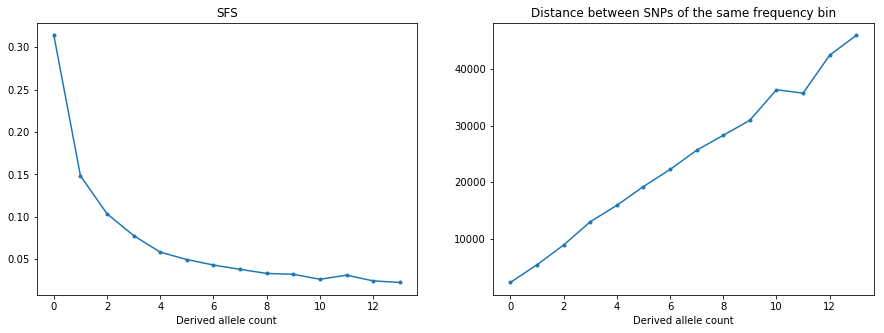

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(res_afs[0], marker='.')
plt.title('SFS')
plt.xlabel('Derived allele count')
plt.subplot(1,2,2)
plt.plot(res_afs[1], marker='.')
plt.title('Distance between SNPs of the same frequency bin')
plt.xlabel('Derived allele count')

### AFIBS ("original" version)
fails for large sample size in which case, favor the version based on BWT (cf further down)

#reload(ss)

In [15]:
# AFIBS (not PBWT version)
# might fail for large sample sizes
res_afibs = ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=False)

Text(0.5,1,'Standard deviation of AFIBS distributions per allele count')

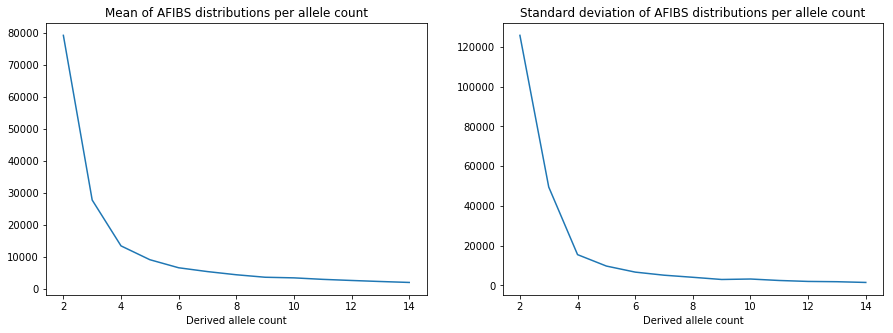

In [16]:
# AFIBS moments (mean, sd)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(2, n_haplo),res_afibs[::2])
plt.xlabel('Derived allele count')
plt.title('Mean of AFIBS distributions per allele count')
plt.subplot(1,2,2)
plt.plot(np.arange(2, n_haplo), res_afibs[1::2])
plt.xlabel('Derived allele count')
plt.title('Standard deviation of AFIBS distributions per allele count')

### AFIBS BWT version
(for full distribution using PBWT and discussion of the algo, see AFIBS_BWT directory and notebook)

In [17]:
# AFIBS algo based on an algorithm proposed by Durbin for IBS tracts using PBWT
res_afibs_bwt = ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=True)

Text(0.5,1,'Standard deviation of AFIBS distributions per allele count')

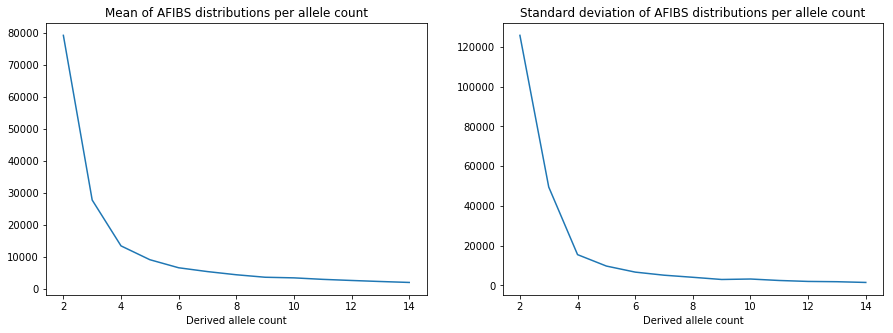

In [18]:
# AFIBS moments (mean, sd)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(2, n_haplo),res_afibs_bwt[::2])
plt.xlabel('Derived allele count')
plt.title('Mean of AFIBS distributions per allele count')
plt.subplot(1,2,2)
plt.plot(np.arange(2, n_haplo), res_afibs_bwt[1::2])
plt.xlabel('Derived allele count')
plt.title('Standard deviation of AFIBS distributions per allele count')

### Distributions of Identical-By-State length 

In [19]:
# Quantiles at which IBS distrib is evaluated
prob_list = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  #sumstats_settings['prob_list']
# Number of haplotypes to compare (max value should be <=n_haplo)
size_list = [2, 4, 6, 8] # sumstats_settings['size_list_hap']
# Maximal distance for calculating IBS [usually set to the size of the segment: L]
dmax = simu_settings['L'] 

res_ibs = dict(zip(size_list, 
         [ss.ibs_quantiles_from_data(size, pos_list, 1, hap_list, prob_list, dmax, quantiles=True, moments=False) for size in size_list]))

res_ibs_mom = dict(zip(size_list, 
         [ss.ibs_quantiles_from_data(size, pos_list, 1, hap_list, prob_list, dmax, quantiles=False, moments=True) for size in size_list]))
pd_ibs_mom = pd.DataFrame(res_ibs_mom, index=['mean', 'variance', 'skewness', 'kurtosis'])
print("1 to 4 order moments as a function of the number of haplotype compared:")
print(pd_ibs_mom)

1 to 4 order moments as a function of the number of haplotype compared:
                    2            4            6           8
mean      1938.166520  1116.800190   867.696895  754.123887
variance  4497.978306  1635.853404  1089.732841  901.272540
skewness    15.060817     5.795059     3.661134    3.150165
kurtosis   417.460987    76.956423    28.656623   21.297957


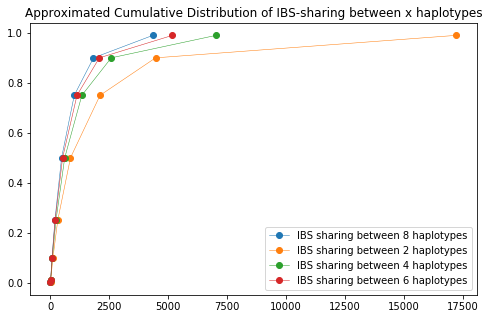

In [20]:
plt.figure(figsize=(8,5))
for i,score in res_ibs.iteritems():
    plt.plot(score, prob_list, label='IBS sharing between {} haplotypes'.format(i), lw=.5, marker='o') 
plt.title('Approximated Cumulative Distribution of IBS-sharing between x haplotypes')
plt.legend()

### Linkage disequilibrium
- Approximation of LD decay as a function of distance between SNPS  
- LD is computed for bin of distance defined by interval_list  
- Warning: computation is slow even though LD is not computed for all pairs  

In [21]:
# Linkage disequilibrium
res_ld = ss.distrib_r2(pos_list,hap_list, sumstats_settings['interval_list'])
intvlcenters = [np.mean(intvl) for intvl in sumstats_settings['interval_list']]

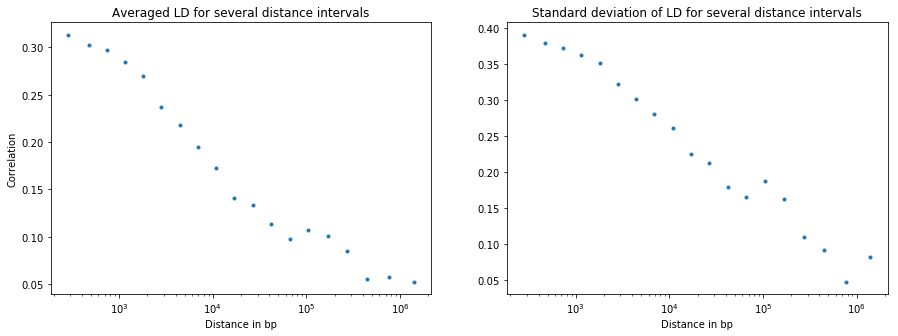

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(intvlcenters, res_ld[0], marker ='.', lw=0)
plt.xlabel('Distance in bp')
plt.ylabel('Correlation')
plt.title('Averaged LD for several distance intervals')
plt.xscale("log")

plt.subplot(1,2,2)
plt.plot(intvlcenters, res_ld[1], marker ='.', lw=0)
plt.xlabel('Distance in bp')
plt.title('Standard deviation of LD for several distance intervals')
plt.xscale("log")